In [1]:
import json
import pandas as pd
import re
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import json
import cv2
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
)

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

caption_root = "/Users/saptarshimallikthakur/Desktop/cvpr2016_flowers/text_c10"
image_root   = "/Users/saptarshimallikthakur/Desktop/jpg"

pairs = []

# Walk through all caption files
for root, _, files in os.walk(caption_root):
    for file in files:
        if not file.endswith(".txt"):
            continue
        
        base_id = file.replace(".txt", "")  # e.g., image_06734
        image_path = os.path.join(image_root, base_id + ".jpg")
        caption_path = os.path.join(root, file)
        
        # Read all 10 captions
        with open(caption_path, 'r') as f:
            captions = [line.strip() for line in f.readlines()]
        
        for caption in captions:
            pairs.append((image_path, caption))

df = pd.DataFrame(pairs).rename(columns={0:'img_path',1:'text'})
df

,img_path,text
0,/Users/saptarshimallikthakur/Desktop/jpg/image...,"this flower is purple and yellow in color, wit..."
1,/Users/saptarshimallikthakur/Desktop/jpg/image...,a pink petal flower with a circular mass of ye...
2,/Users/saptarshimallikthakur/Desktop/jpg/image...,many light purple petals surround a large grou...
3,/Users/saptarshimallikthakur/Desktop/jpg/image...,this flower has thin purple petals as its main...
4,/Users/saptarshimallikthakur/Desktop/jpg/image...,the flower shown has purple petals with yellow...
...,...,...
81885,/Users/saptarshimallikthakur/Desktop/jpg/image...,this flower has linear bright pink petals with...
81886,/Users/saptarshimallikthakur/Desktop/jpg/image...,"this flower is pink and yellow in color, and h..."
81887,/Users/saptarshimallikthakur/Desktop/jpg/image...,these flowers have long oval shaped pink petal...
81888,/Users/saptarshimallikthakur/Desktop/jpg/image...,this flower has bright pink oblong petals with...


In [3]:
# 1) Text cleaning ------------------------------------------------------
def clean_text(text: str) -> str:
    """
    Remove HTML, normalize whitespace, preserve punctuation/numbers/casing.
    """
    # text = text.lower()
    text = re.sub(r'<image>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z0-9.,!?]+', ' ', text)
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df['text'] = df['text'].apply(lambda x: clean_text(x))

# Combine summary + dialogue and split on whitespace
raw_lens = [
    len(f"{s}".split()) 
    for s in tqdm(df['text'], total=len(df))
]

lens = np.array(raw_lens)

# Print summary stats
def pct(x): return np.percentile(lens, x)

MAX_LEN = int(pct(99))

text_pairs = []

for img,i in zip(df.img_path,df.text):
    try:
        if len(i.split(" ")) < MAX_LEN: 
            text_pairs.append((img,i,))
    except:
        pass

100%|██████████| 81890/81890 [00:00<00:00, 1975291.31it/s]


In [4]:
len(text_pairs)

80921

In [5]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing
from tokenizers import models, trainers, pre_tokenizers

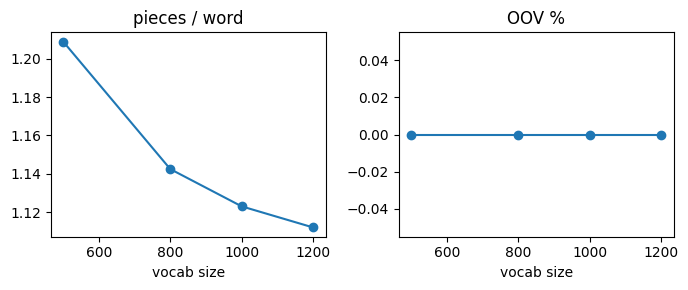

In [6]:
# ── assume train_df already loaded ─────────────────────────────────────
rng            = np.random.default_rng(42)
valid_mask     = rng.random(len(df)) < 0.25          # 25 % hold-out
train_df_, valid_df = df[~valid_mask], df[valid_mask]

# ⇢ cache validation texts so we can loop over them many times
valid_texts = [f"{s}" for s in valid_df["text"]]

def train_tokenizer(text_iter, vocab_size: int) -> Tokenizer:
    tok = Tokenizer(models.BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size,
                                  min_frequency=2,
                                  special_tokens=["[UNK]"])
    tok.train_from_iterator(text_iter, trainer)
    return tok

def avg_pieces_per_word(tok: Tokenizer, texts) -> float:
    pieces = words = 0
    for t in texts:
        ids   = tok.encode(t).ids
        pieces += len(ids)
        words  += len(t.split())
    return pieces / words

vocab_sizes = [500, 800, 1000,1200]
pieces_per_word, oov_rate = [], []

for k in vocab_sizes:
    train_iter = (f"{s}" for s in train_df_["text"])
    tok = train_tokenizer(train_iter, k)

    # 1) average sub-words per word on validation set
    pieces_per_word.append(avg_pieces_per_word(tok, valid_texts))

    # 2) OOV percentage on validation set
    unk_id = tok.token_to_id("[UNK]")
    total = unk = 0
    for t in valid_texts:
        ids   = tok.encode(t).ids
        total += len(ids)
        unk   += sum(id_ == unk_id for id_ in ids)
    oov_rate.append(100 * unk / total)

# ── plot ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.plot(vocab_sizes, pieces_per_word, marker='o')
plt.title("pieces / word"); plt.xlabel("vocab size")

plt.subplot(1,2,2)
plt.plot(vocab_sizes, oov_rate, marker='o')
plt.title("OOV %"); plt.xlabel("vocab size")

plt.tight_layout(); plt.show()

In [7]:
VOCAB_SIZE = 1000

CORPUS_FILE = 'all_texts.txt'
SPECIAL_TOKENS = ['[PAD]','[UNK]','[BOS]','[EOS]','[SEP]','[IMG_TOKEN]']  

with open(CORPUS_FILE, 'w', encoding='utf-8') as f:
    for _, row in df.iterrows():
        f.write(str(row['text']))

100%|██████████| 81890/81890 [00:01<00:00, 55655.27it/s]


Total samples    : 81,890
Min / Max tokens : 0 / 92
Mean ± std       : 15.3 ± 4.7
--- percentiles (tokens) ---
 50% : 14
 90% : 21
 95% : 24
 98% : 29
 99% : 33


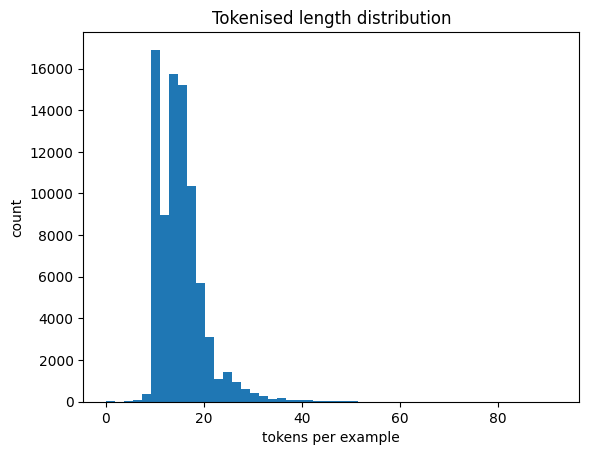

In [8]:
# Initialize and train
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=SPECIAL_TOKENS)
tokenizer.train([CORPUS_FILE], trainer)

# 3) Configure post-processing, padding & truncation ------------------
pad_id = tokenizer.token_to_id('[PAD]')
unk_id = tokenizer.token_to_id('[UNK]')
bos_id = tokenizer.token_to_id('[BOS]')
eos_id = tokenizer.token_to_id('[EOS]')
sep_id = tokenizer.token_to_id('[SEP]')
img_token_id = tokenizer.token_to_id('[IMG_TOKEN]')

# Add BOS/EOS around single sequences
tokenizer.post_processor = TemplateProcessing(
    single='$A',
    special_tokens=[('[BOS]', bos_id), ('[EOS]', eos_id),('[SEP]', sep_id),('[IMG_TOKEN]',img_token_id)]
)

# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for s in tqdm(df["text"],total=len(df)):
    ids   = tok.encode(f'{s}').ids
    lens.append(len(ids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [9]:
BATCH_SIZE     = 32
NUM_IMG_TOKENS = 14*14
PAD_ID         = pad_id
IMG_TOK        = img_token_id

# pre-compute how many tokens you reserve for
# [BOS], [SEP], image-tokens, [EOS]
FIXED_LEN      = 1 + 1 + NUM_IMG_TOKENS + 1  
MAX_TEXT_LEN   = int(pct(99))
MAX_LEN = MAX_TEXT_LEN + FIXED_LEN

def encode_pair(text_a: str) -> np.ndarray:
    # 1) get the raw text IDs
    text_ids = tokenizer.encode(text_a).ids

    # 2) truncate text_ids if it's too long
    if len(text_ids) > MAX_TEXT_LEN:
        text_ids = text_ids[:MAX_TEXT_LEN]

    # 3) build the full sequence
    enc = (
        [tokenizer.encode('[BOS]').ids[0]]  # or just [bos_id]
        + text_ids
        + [tokenizer.encode('[SEP]').ids[0]]  # or [sep_id]
        + [IMG_TOK] * NUM_IMG_TOKENS
        + [tokenizer.encode('[EOS]').ids[0]]  # or [eos_id]
    )

    # 4) pad on the right if still short
    if len(enc) < MAX_LEN:
        enc += [PAD_ID] * (MAX_LEN - len(enc))

    # at this point, len(enc) == MAX_LEN
    return np.array(enc, dtype=np.int32)

def encode_example(img_path, text: str):
    ids = encode_pair(text)           # np.ndarray, shape=[MAX_LEN]
    labels = np.concatenate([ids[1:], [pad_id]])  # shape=[MAX_LEN]

    # find SEP
    sep_idxs = np.where(labels == sep_id)[0]
    sep_pos = int(sep_idxs[0]) if sep_idxs.size else len(ids)

    # build base mask: 1 only for positions > sep_pos AND not PAD
    positions = np.arange(len(labels))
    loss_mask = (positions > sep_pos).astype(np.float32) * (labels != pad_id).astype(np.float32)

    return img_path, ids, labels.astype(np.int32), loss_mask

In [10]:
# ── 0. do *all* tokenisation once ──────────────────────────
triples = [encode_example(img, t) for (img, t) in text_pairs]   # Python loop, done **once**
img_path, ids, labels, masks = map(lambda k: tf.constant(np.stack(k, 0)),zip(*triples))                      # shapes [N, MAX_LEN]

# ── 1. build the purely-TF dataset ─────────────────────────
ds = (
    tf.data.Dataset.from_tensor_slices({'img_path':img_path,"input_ids": ids, "labels": labels, "loss_mask": masks})
    .shuffle(len(text_pairs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

del(triples)
del(img_path)
del(ids)
del(labels)
del(masks)

2025-06-30 09:21:34.675071: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-30 09:21:34.675096: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-30 09:21:34.675100: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1751255494.675112 11398190 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1751255494.675134 11398190 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Get the full vocab: token → id
vocab_dict = tokenizer.get_vocab()

# To sort it by ID (optional, for better readability)
sorted_vocab = dict(sorted(vocab_dict.items(), key=lambda item: item[1]))
print(sorted_vocab)

del(vocab_dict)
del(sorted_vocab)

{'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3, '[SEP]': 4, '[IMG_TOKEN]': 5, '!': 6, ',': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, '?': 19, 'a': 20, 'b': 21, 'c': 22, 'd': 23, 'e': 24, 'f': 25, 'g': 26, 'h': 27, 'i': 28, 'j': 29, 'k': 30, 'l': 31, 'm': 32, 'n': 33, 'o': 34, 'p': 35, 'q': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'w': 42, 'x': 43, 'y': 44, 'z': 45, 'th': 46, 'lo': 47, 'er': 48, 'low': 49, 'ta': 50, 'pe': 51, 'is': 52, 'an': 53, 'in': 54, 're': 55, 'tal': 56, 'petal': 57, 'flow': 58, 'flower': 59, 'ha': 60, 'petals': 61, 'and': 62, 'this': 63, 'has': 64, 'en': 65, 'el': 66, 'at': 67, 'wi': 68, 'are': 69, 'with': 70, 'the': 71, 'le': 72, 'te': 73, 'that': 74, 'yel': 75, 'yellow': 76, 'wh': 77, 'whi': 78, 'white': 79, 'ar': 80, 'ur': 81, 'ge': 82, 'pin': 83, 'co': 84, 'pink': 85, 'men': 86, 'colo': 87, 'sta': 88, 'ple': 89, 'of': 90, 'pur': 91, 'stamen': 92, 'purple': 93, 'ig': 94, 'ro': 95, 'color': 96, '

In [12]:
vocab = tokenizer.get_vocab()           # indices 0 … V

id_to_token = {idx: tok for tok, idx in vocab.items()}

# 2) Decoder: drop PADs
def decode_token_ids(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid == pad_id:
            continue
        tok = id_to_token.get(tid, '?')
        if tok == '$':
            continue  # Skip the '$' symbol
        if tok.startswith('Ġ'):
            tok = tok[1:]  # Remove the space prefix indicator
            tokens.append(' ' + tok)
        else:
            tokens.append(tok)
    return ' '.join(tokens).strip()

# 3) Inspect one batch from your TF dataset
for batch in ds.take(10):
    pth = batch['img_path'].numpy()
    input_ids = batch['input_ids'].numpy()  # shape (batch, MAX_LEN)
    labels    = batch['labels'].numpy()

    for i, (pth, ids_row, lbl_row) in enumerate(zip(pth, input_ids, labels), start=1):
        print(f"\n🟢 Sample {i}")
        print("  pth: ", pth)
        print("  Input IDs: ", ids_row.tolist())
        print("  Decoded:   ", decode_token_ids(ids_row.tolist()))
        print("  Label IDs: ", lbl_row.tolist())


🟢 Sample 1
  pth:  b'/Users/saptarshimallikthakur/Desktop/jpg/image_01797.jpg'
  Input IDs:  [2, 63, 59, 64, 61, 74, 69, 76, 7, 70, 20, 79, 62, 98, 121, 62, 131, 76, 151, 8, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Decoded:    [BOS] this flower has petals that are yellow , with a white and red center and large yellow stigma . [SEP] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOK

2025-06-30 09:21:35.161031: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for batch in ds.take(1):
    img_pth = batch['img_path']
    input_ids = batch["input_ids"]
    labels    = batch["labels"]
    loss_mask = batch["loss_mask"]

    for i, (pth, ids_row, lbl_row,mask) in enumerate(zip(img_pth,input_ids, labels, loss_mask), start=1):
        print(f"\n🟢 Sample {i}")
        print("  img_path: ",pth)
        print("  Input IDs: ",ids_row)
        print("  Target IDs: ",lbl_row)
        print("  Loss Mask: ",mask)


🟢 Sample 1
  img_path:  tf.Tensor(b'/Users/saptarshimallikthakur/Desktop/jpg/image_04440.jpg', shape=(), dtype=string)
  Input IDs:  tf.Tensor(
[  2  20  59  70 131 411 933  98  61   7 343  22 997  38 113 158  62 283
   7  62 105 797   8   4   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5

2025-06-30 09:21:35.501194: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
for batch in ds.take(1):
    input_ids = batch["input_ids"]
    labels    = batch["labels"]
    loss_mask = batch["loss_mask"]
    
j=19
print(loss_mask[j])
print('\n',decode_token_ids(batch["labels"][j].numpy()))

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(232,), dtype=float32)

 this flower is yellow in color , with petals that are bunched together . [SEP] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IM

In [15]:
batch["input_ids"].shape, batch["labels"].shape,batch["loss_mask"].shape

(TensorShape([32, 232]), TensorShape([32, 232]), TensorShape([32, 232]))

In [16]:
# --- Keep your ResidualBlock the same ---
class ResidualBlock(layers.Layer):
    def __init__(self, filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, padding='same', use_bias=False, kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.activation = layers.Activation('relu')
        self.se    = tf.keras.Sequential([
                       layers.GlobalAveragePooling2D(),
                       layers.Dense(filters//4, activation='relu'),
                       layers.Dense(filters, activation='sigmoid'),
                       layers.Reshape((1,1,filters))
                     ])

    def call(self, x, training=False):
        residual = x
        y = self.activation(self.bn1(self.conv1(x), training=training))
        y = y*self.se(y,training=training)
        y += residual
        return y

# --- REVISED VQVAE with Codebook Resetting ---
class VQVAE(tf.keras.Model):
    def __init__(self,num_embeddings=1024, embedding_dim=256):
        super(VQVAE, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        # --- Encoder remains the same ---
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(self.embedding_dim//16, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal', input_shape=(224,224,3)),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim//16),

            layers.Conv2D(self.embedding_dim//8, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim//8),

            layers.Conv2D(self.embedding_dim//4, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim//4),

            layers.Conv2D(self.embedding_dim//2, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim//2),

            # **Linear projection to latent z_e(x) (no activation, no BN)**
            layers.Conv2D(self.embedding_dim,kernel_size=3,padding='same', use_bias=True)           # bias is OK when no BN
        ])

        # --- Embedding Layer and Usage Tracker ---
        self.embedding = layers.Embedding(self.num_embeddings, self.embedding_dim)
        H,W = 14,14
        self.embedding.build((None,H*W))
 
        # We use a non-trainable variable to track code usage.
        self.codebook_usage = tf.Variable(tf.zeros(self.num_embeddings), trainable=False, name='codebook_usage')

        # --- Decoder remains the same, but ensure the final Conv matches embedding_dim ---
        self.decoder = tf.keras.Sequential([

            layers.Conv2DTranspose(self.embedding_dim, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal', input_shape=(14,14,self.embedding_dim)),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim),

            layers.Conv2DTranspose(self.embedding_dim//2, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim//2),

            layers.Conv2DTranspose(self.embedding_dim//4, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'), 
            ResidualBlock(self.embedding_dim//4),

            layers.Conv2DTranspose(self.embedding_dim//8, kernel_size=2, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'),
            ResidualBlock(self.embedding_dim//8),

            layers.Conv2D(self.embedding_dim//16, kernel_size=3,padding='same', use_bias=False, kernel_initializer='he_normal'),
            layers.BatchNormalization(), 
            layers.Activation('relu'),
            ResidualBlock(self.embedding_dim//16),

            layers.Conv2D(3, kernel_size=3, padding='same', use_bias=True, activation='sigmoid')
        ])

    def call(self, x, training=False):
        z = self.encoder(x, training=training)
        B, H, W, C = tf.unstack(tf.shape(z))
        z_flat = tf.reshape(z, [-1, self.embedding_dim])

        e = self.embedding.weights[0]
        dist = (tf.reduce_sum(z_flat**2, 1, keepdims=True)
                - 2 * tf.matmul(z_flat, e, transpose_b=True)
                + tf.reduce_sum(e**2, 1))

        k = tf.argmin(dist, axis=1) # The indices of the chosen codes
        e_q = tf.gather(e, k)

        # Update usage statistics during training
        if training:

            # EXPONENTIAL DECAY
            decay = 0.99         
            self.codebook_usage.assign(self.codebook_usage * decay)

            # Get one-hot representation of which codes were used
            k_one_hot = tf.one_hot(k, self.num_embeddings)
            # Sum up usage across the batch
            usage_in_batch = tf.reduce_sum(k_one_hot, axis=0)
            # Update the long-term usage tracker
            self.codebook_usage.assign_add(usage_in_batch)

        commitment_loss = tf.reduce_mean(tf.square(z_flat - tf.stop_gradient(e_q)))
        codebook_loss = tf.reduce_mean(tf.square(tf.stop_gradient(z_flat) - e_q))

        z_q = tf.reshape(z_flat + tf.stop_gradient(e_q - z_flat), [B, H, W, C])
        x_hat = self.decoder(z_q, training=training)

        return x_hat, commitment_loss, codebook_loss, z_flat # Return z_flat for resetting

    # @tf.function # Compile this function for speed
    def reset_dead_codes(self, z_batch_flat):
        """
        Resets dead codes to random encoder outputs from the current batch.
        """
        # Find which codes are unused
        dead_indices = tf.where(self.codebook_usage < 1.0)
        num_dead = tf.shape(dead_indices)[0]

        if num_dead == 0:
            return None
        
        # Get random encoder outputs from the batch to use as replacements
        num_replacements = tf.shape(z_batch_flat)[0]
        random_indices = tf.random.uniform(shape=[num_dead], maxval=num_replacements, dtype=tf.int32)
        replacements = tf.gather(z_batch_flat, random_indices)

        # Get current codebook and update the dead codes
        current_codebook = self.embedding.weights[0]
        updated_codebook = tf.tensor_scatter_nd_update(current_codebook, dead_indices, replacements)

        # Assign the updated codebook back to the embedding layer
        self.embedding.set_weights([updated_codebook])
        
        # Also reset the usage counter for the revived codes to 1 so they aren't immediately reset again
        reset_usage_values = tf.ones(num_dead, dtype=tf.float32)
        updated_usage = tf.tensor_scatter_nd_update(self.codebook_usage, dead_indices, reset_usage_values)
        self.codebook_usage.assign(updated_usage)

        tf.print("Reset", num_dead, "dead codes.")
        return None
    
    def get_embedding(self,x,training=False):

        z = self.encoder(x, training=training)
        B, H, W, C = tf.unstack(tf.shape(z))
        z_flat = tf.reshape(z, [-1, self.embedding_dim])

        e = self.embedding.weights[0]
        dist = (tf.reduce_sum(z_flat**2, 1, keepdims=True)
                - 2 * tf.matmul(z_flat, e, transpose_b=True)
                + tf.reduce_sum(e**2, 1))

        k = tf.argmin(dist, axis=1) # The indices of the chosen codes
        emb = tf.gather(e, k)

        emb = tf.reshape(emb,(B,H*W,C))
        k = tf.reshape(k,(B,-1))
        
        return emb,k
    
    def decode_indices(self,indices):
        return self.embedding(indices)
    
    def get_config(self):
        # return exactly the args your __init__ needs
        return {
            "num_embeddings": self.num_embeddings,
            "embedding_dim":  self.embedding_dim,
        }

    @classmethod
    def from_config(cls, config):
        # drop any extra keys that Keras will inject
        # (trainable, dtype, etc.)
        config.pop("trainable", None)
        config.pop("dtype",     None)
        return cls(**config)
    

custom_objs = {
    "VQVAE":         VQVAE,
    "ResidualBlock": ResidualBlock,
}

# Load the SavedModel (no more __init__ errors)
emb_model = tf.keras.models.load_model(
    "VQVAE/vqvae.keras",
    custom_objects=custom_objs,
    compile=False
)

# And immediately switch off training bits
emb_model.trainable = False

emb_model.summary()

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "vqvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 14, 14, 256)    │       547,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 196, 256)       │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (None, 224, 224, 3)    │     1,273,119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,082,571 (7.94 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,082,571 (7.94 MB)

In [17]:
x = tf.random.normal((32,224,224,3))
embeddings, indices = emb_model.get_embedding(x)
indices = indices+VOCAB_SIZE

In [18]:
emb_model.num_embeddings

1024

In [19]:
embeddings, indices

(<tf.Tensor: shape=(32, 196, 256), dtype=float32, numpy=
 array([[[ 10.121553  ,  -2.28609   ,   1.799656  , ...,  -1.0667776 ,
           -0.546978  ,  -1.5616146 ],
         [ -1.7629893 ,  -2.7012346 ,  11.890301  , ...,  15.125468  ,
           -2.8852398 ,  -7.3756776 ],
         [ 10.271022  ,   7.726749  ,   8.952642  , ...,   2.2917616 ,
           -1.3145001 ,  -1.6484861 ],
         ...,
         [ 10.121553  ,  -2.28609   ,   1.799656  , ...,  -1.0667776 ,
           -0.546978  ,  -1.5616146 ],
         [ 10.121553  ,  -2.28609   ,   1.799656  , ...,  -1.0667776 ,
           -0.546978  ,  -1.5616146 ],
         [  5.5632744 , -15.184697  ,  -5.1525784 , ...,   6.9332705 ,
          -11.677466  ,  -6.8115907 ]],
 
        [[  5.5632744 , -15.184697  ,  -5.1525784 , ...,   6.9332705 ,
          -11.677466  ,  -6.8115907 ],
         [ 10.271022  ,   7.726749  ,   8.952642  , ...,   2.2917616 ,
           -1.3145001 ,  -1.6484861 ],
         [  3.7587438 ,  -5.686242  ,   3.8173

In [20]:
emb_model.decode_indices(indices-VOCAB_SIZE)

<tf.Tensor: shape=(32, 196, 256), dtype=float32, numpy=
array([[[ 10.121553  ,  -2.28609   ,   1.799656  , ...,  -1.0667776 ,
          -0.546978  ,  -1.5616146 ],
        [ -1.7629893 ,  -2.7012346 ,  11.890301  , ...,  15.125468  ,
          -2.8852398 ,  -7.3756776 ],
        [ 10.271022  ,   7.726749  ,   8.952642  , ...,   2.2917616 ,
          -1.3145001 ,  -1.6484861 ],
        ...,
        [ 10.121553  ,  -2.28609   ,   1.799656  , ...,  -1.0667776 ,
          -0.546978  ,  -1.5616146 ],
        [ 10.121553  ,  -2.28609   ,   1.799656  , ...,  -1.0667776 ,
          -0.546978  ,  -1.5616146 ],
        [  5.5632744 , -15.184697  ,  -5.1525784 , ...,   6.9332705 ,
         -11.677466  ,  -6.8115907 ]],

       [[  5.5632744 , -15.184697  ,  -5.1525784 , ...,   6.9332705 ,
         -11.677466  ,  -6.8115907 ],
        [ 10.271022  ,   7.726749  ,   8.952642  , ...,   2.2917616 ,
          -1.3145001 ,  -1.6484861 ],
        [  3.7587438 ,  -5.686242  ,   3.817396  , ...,   2.65618

In [21]:
def apply_rope(x, sin, cos):
    """
    x   : (B, h, T, d) even-sized last dim (d must be multiple of 2)
    sin : (T, d//2)     broadcastable
    cos : (T, d//2)
    """
    #This separates each feature vector's dimensions into 2 halves — like real and imaginary parts.
    x_even = x[..., 0::2]      # Get even-dimension values → shape: (B, h, T, d/2)
    x_odd  = x[..., 1::2]      # Get odd-dimension values → shape: (B, h, T, d/2)

    # This is a 2D rotation formula applied to each positional index and head.
    # It "rotates" the embedding vector in its dimensional space based on position.
    x_rot_even =  x_even *  cos - x_odd * sin
    x_rot_odd  =  x_even *  sin + x_odd * cos
    
    # interleave even/odd back together
    x_rot = tf.stack([x_rot_even, x_rot_odd], axis=-1)   # (..., d/2, 2)
    return tf.reshape(x_rot, tf.shape(x))                # (..., d)

def make_sincos(seq_len, dim, base=10000):
    '''
    Returns sin, cos with shape (seq_len, dim//2)
    '''
    pos = tf.cast(tf.range(seq_len), tf.float32)                       # (T,)
    i   = tf.cast(tf.range(0, dim, 2), tf.float32) / dim              # (d/2,)
    theta = pos[:, None] / (base ** i[None, :])                       # (T, d/2)
    return tf.sin(theta), tf.cos(theta)

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Vanilla multi-head (scaled-dot-product) attention implemented from scratch.

    Args
    ----
    d_model     : int   – total embedding size (must be divisible by num_heads)  
    num_heads   : int   – number of attention heads  
    dropout     : float – dropout on attention weights (0.0 = no dropout)

    Call Signature
    --------------
    output, attn_scores = mha(
        query,                     # (B, T_q, d_model)
        value=None,                # (B, T_v, d_model)  – defaults to query
        key=None,                  # (B, T_k, d_model)  – defaults to value
        mask=None,                 # (B, 1, T_q, T_k) or (B, T_q, T_k)
        use_causal_mask=False,     # True → autoregressive causal mask
        training=None
    )
    """
    def __init__(self, d_model, num_heads, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        if d_model % num_heads != 0:
            raise ValueError(
                f"d_model={d_model} must be divisible by num_heads={num_heads}"
            )

        self.d_model   = d_model
        self.num_heads = num_heads
        self.depth     = d_model // num_heads

        # Linear projections for Q, K, V and final output
        self.wq   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wk   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wv   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wo   = tf.keras.layers.Dense(d_model, use_bias=False)

        self.dropout = tf.keras.layers.Dropout(dropout)

    # ────────────────────────────────────────────────────────────────────────
    # Helpers
    # ────────────────────────────────────────────────────────────────────────
    def _split_heads(self, x, B):
        """
        Reshape (B, T, d_model) → (B, num_heads, T, depth)
        so we can run attention on each head in parallel.
        """
        x = tf.reshape(x, (B, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    @staticmethod
    def _scaled_dot_product_attention(q, k, v, mask, dropout,training=None):
        """
        Core attention: softmax(QKᵀ / √d_k) V
        Returns: (B, h, T_q, depth_v), (B, h, T_q, T_k)
        """
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)  # (B,h,T_q,T_k)

        if mask is not None:
            # broadcast automatically if mask rank < scores rank
            scores += (mask * -1e9)  # large negative → zero probability

        attn = tf.nn.softmax(scores, axis=-1)
        attn = dropout(attn,training=training)
        output = tf.matmul(attn, v)  # (B,h,T_q,depth)
        return output

    # ────────────────────────────────────────────────────────────────────────
    # Forward pass
    # ────────────────────────────────────────────────────────────────────────
    def call(
        self,
        query,
        value=None,
        key=None,
        mask=None,
        use_causal_mask=False,
        training=None
    ):
        if value is None:
            value = query
        if key is None:
            key = value

        B = tf.shape(query)[0]
        Tq = tf.shape(query)[1]          # sequence length of Q
        Tk = tf.shape(key)[1]

        # 1. Linear projections
        q = self.wq(query)   # (B, T_q, d_model)
        k = self.wk(key)     # (B, T_k, d_model)
        v = self.wv(value)   # (B, T_v, d_model)

        # 2. Reshape for multi-head
        q = self._split_heads(q, B)  # (B, h, T_q, depth)
        k = self._split_heads(k, B)  # (B, h, T_k, depth)
        v = self._split_heads(v, B)  # (B, h, T_v, depth)

        # 3) -----------------  ROTARY  -----------------
        # Build sin/cos for the longest sequence we need this step
        max_len = tf.maximum(Tq, Tk)
        sin, cos = make_sincos(max_len, self.depth)       # depth = d_model / num_heads

        # Slice sin/cos to actual lengths (broadcast works automatically)
        # RoPE modifies Q and K such that their dot product reflects not just content similarity but also relative position.
        q = apply_rope(q, sin[:Tq], cos[:Tq])             # rotate Q
        k = apply_rope(k, sin[:Tk], cos[:Tk])             # rotate K
        # ----------------------------------------------

        # 3. (Optional) Causal mask: block future positions
        if use_causal_mask:
            T_q = tf.shape(q)[2]
            T_k = tf.shape(k)[2]
            causal = 1.0 - tf.linalg.band_part(tf.ones((T_q, T_k)), -1, 0)  # lower-tri  # 1 → masked
            causal = causal[tf.newaxis, tf.newaxis, :, :]  # (1,1,T_q,T_k)
            mask = causal if mask is None else tf.maximum(mask, causal)

        # 4. Scaled dot-product attention
        attn_out = self._scaled_dot_product_attention(
            q, k, v, mask, self.dropout,training=training,
        )  # (B,h,T_q,depth), (B,h,T_q,T_k)

        # 5. Concatenate heads
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (B,T_q,h,depth)
        attn_out = tf.reshape(attn_out, (B, -1, self.d_model))  # (B,T_q,d_model)

        # 6. Final linear layer
        output = self.wo(attn_out)  # (B,T_q,d_model)

        return output
    
class RMSNorm(tf.keras.layers.Layer):
    def __init__(self, hidden_size, epsilon=1e-8, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.epsilon = epsilon
        
        # Learnable scale parameter γ (same shape as last dim of input)
        self.scale = self.add_weight(
            name="scale",
            shape=(self.hidden_size,),
            initializer="ones",
            trainable=True
        )

    def call(self, x):
        rms = tf.sqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + self.epsilon)
        norm_x = x / rms
        return norm_x * self.scale

class CausalSelfAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        self.mha = MultiHeadAttention(d_model=d_model,num_heads=num_heads,dropout=dropout)
        self.rmsnorm = RMSNorm(d_model)
        self.add = tf.keras.layers.Add()

    def call(self, x, padding_mask=None, training=None):

        rms_x1 = self.rmsnorm(x)
        attn_output = self.mha(
            query=rms_x1, value=rms_x1, key=rms_x1,
            mask=padding_mask,          # may be None
            use_causal_mask=True,
            training=training,
        )
        rms_x1 = self.add([x, attn_output])
        return rms_x1

In [22]:
class SwiGLU(tf.keras.layers.Layer):
    def __init__(self, hidden_dim,factor=4):
        super().__init__()
        self.lin1 = tf.keras.layers.Dense(factor*hidden_dim,use_bias=False)   # W1
        self.lin2 = tf.keras.layers.Dense(hidden_dim,use_bias=False)       # W2

    def call(self, x):
        x_ = self.lin1(x)                          # shape: (..., 4d)
        a, b = tf.split(x_, num_or_size_splits=2, axis=-1)  # split
        gated = a * (b * tf.sigmoid(b))            # SwiGLU: a ⊙ SiLU(b)
        return self.lin2(gated)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super().__init__()

        self.seq = tf.keras.Sequential(
            [
                SwiGLU(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.rmsnorm = RMSNorm(d_model)

    def call(self, x, training=None):
        y = self.seq(self.rmsnorm(x), training=training)  # pre-norm
        return x + y                                  # residual on raw x
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, d_model=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model)

    def call(self, x, padding_mask=None, training=None):
        x = self.causal_self_attention(x, padding_mask=padding_mask, training=training)
        x = self.ffn(x,training=training)
        return x

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dropout_rate=0.1,pad_token_id = pad_id):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.pad_token_id = pad_token_id
        self.token_embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+emb_model.num_embeddings,output_dim=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.last_attn_scores = None

    def call(self, inputs, training=None):

        # Get the padding mask
        padding_mask = tf.cast(tf.equal(inputs, self.pad_token_id), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Get the standard text embeddings for the whole sequence
        text_emb = self.token_embedding(inputs)

        x = self.dropout(text_emb, training=training)
        for layer in self.dec_layers:
            x = layer(x, padding_mask=padding_mask, training=training)
            
        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.img_embedding_model = emb_model 
        self.img_token_id = img_token_id
        
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,num_heads=num_heads, dropout_rate=dropout_rate)

        self.rmsnorm = RMSNorm(d_model)
        self.final_layer = tf.keras.layers.Dense(VOCAB_SIZE + self.img_embedding_model.num_embeddings)

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker  = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")

        # Per-token CE (no built-in reduction)
        self._ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

    @property
    def metrics(self):
        # Keras resets these each epoch
        return [self.loss_tracker, self.acc_tracker]

    def call(self, inputs, training=False):
        final_embeddings = self.decoder(inputs, training=training)
        final_embeddings = self.rmsnorm(final_embeddings)
        logits = self.final_layer(final_embeddings)
        return logits
    
    def train_step(self, data):
        # Unpack data. It's what you pass to `model.fit()`.
        image_input, token_input, label_input, loss_mask = data

        _, vq_indices = self.img_embedding_model.get_embedding(image_input, training=False)
        vq_indices += VOCAB_SIZE
        vq_indices = tf.cast(vq_indices, dtype=label_input.dtype)

        is_img_target = (token_input == self.img_token_id)
        scatter_indices = tf.cast(tf.where(is_img_target), dtype=tf.int32)
        vq_indices_flat = tf.reshape(vq_indices, [-1]) # (N,)
        vq_indices_scattered = tf.scatter_nd(scatter_indices, vq_indices_flat, shape=tf.shape(token_input))
        final_input = tf.where(is_img_target, vq_indices_scattered, token_input)

        is_img_target = (label_input == self.img_token_id)
        scatter_indices = tf.cast(tf.where(is_img_target), dtype=tf.int32)
        vq_indices_flat = tf.reshape(vq_indices, [-1]) # (N,)
        vq_indices_scattered = tf.scatter_nd(scatter_indices, vq_indices_flat, shape=tf.shape(label_input))
        final_labels = tf.where(is_img_target, vq_indices_scattered, label_input)
        
        with tf.GradientTape() as tape:
            # Get the logits from the forward pass
            logits = self.call(final_input, training=True)
            tok_loss = self._ce(final_labels, logits)
            loss = tf.reduce_sum(tok_loss * loss_mask) / tf.reduce_sum(loss_mask)

        # Compute gradients and update weights
        grads = tape.gradient(loss, self.trainable_variables)
        grads = [tf.clip_by_norm(g, 1.0) for g in grads]
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        
        # Update metrics
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(final_labels, logits, sample_weight=loss_mask)
        return {m.name: m.result() for m in self.metrics}
    
    def generate(self, text_prompt_tokens, num_img_tokens=196, temperature=1.0):

        # We start our generation with the text prompt.
        prompt_tensor = tf.constant([text_prompt_tokens], dtype=tf.int32)
        
        # The generation loop
        generated_sequence = prompt_tensor
        for _ in range(num_img_tokens):
            
            # Get logits from the model
            logits = self.call(generated_sequence, training=False)
            
            # Focus on the logits for the very last token
            last_token_logits = logits[:, -1, :]

            # Apply temperature and sample the next token (an image code)
            scaled_logits = last_token_logits / temperature
            next_token_id = tf.random.categorical(scaled_logits, num_samples=1, dtype=tf.int32)
            
            # Append the new image code to our sequence
            generated_sequence = tf.concat([generated_sequence, next_token_id], axis=1)

        # Return only the generated image codes, excluding the prompt
        # The prompt has length `tf.shape(prompt_tensor)[1]`
        start_index = tf.shape(prompt_tensor)[1]
        generated_image_codes = generated_sequence[0, start_index:]
                
        return generated_image_codes-VOCAB_SIZE

In [24]:
num_layers = 6
d_model = 256
num_heads = 8
dropout_rate = 0.1
EPOCHS = 10

IMG_SHAPE = (224, 224, 3)

def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SHAPE[:2])/255
    return img

model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dropout_rate=0.1
)

input_ids = batch["input_ids"]

_ = model(input_ids)             
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vqvae (VQVAE)                   │ ?                      │     2,082,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │     4,453,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rms_norm_12 (RMSNorm)           │ ?                      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (32, 232, 2024)        │       520,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,056,371 (26.92 MB)

 Trainable params: 4,973,800 (18.97 MB)

 Non-trainable params: 2,082,571 (7.94 MB)

In [25]:
WARM_FRAC   = 0.1        # keep the fast ramp-up
DECAY_RATE  = 4
LR_FLOOR    = 1e-6
LR_PEAK_DESIRED = 5e-4     

# pre-compute the scale that gives that peak
num_steps     = EPOCHS * len(text_pairs) // BATCH_SIZE
warmup_steps  = int(num_steps * WARM_FRAC)
current_peak  = 1.0 / tf.sqrt(tf.cast(d_model * warmup_steps, tf.float32))
LR_SCALE      = LR_PEAK_DESIRED / current_peak.numpy()

@tf.keras.utils.register_keras_serializable()   # so it can round-trip in SavedModel/H5
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, total_steps=num_steps,
                 warmup_frac=WARM_FRAC, decay_rate=DECAY_RATE,
                 lr_scale=LR_SCALE):
        super().__init__()
        self.d_model      = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(int(total_steps * warmup_frac), tf.float32)
        self.decay_rate   = decay_rate
        self.decay_steps  = tf.cast(total_steps, tf.float32)
        self.lr_scale     = tf.cast(lr_scale, tf.float32)

    def __call__(self, step):
        step  = tf.cast(step, tf.float32)
        arg1  = tf.math.rsqrt(step)
        arg2  = step * tf.math.pow(self.warmup_steps, -1.5)
        warm  = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        decay = tf.math.exp(-self.decay_rate *
                            tf.maximum(step - self.warmup_steps, 0.) /
                            self.decay_steps)
        lr = warm * decay * self.lr_scale 
        return tf.maximum(lr, LR_FLOOR)

    # ----------  NEW  ----------
    def get_config(self):
        return {
            "d_model":      int(self.d_model.numpy()),   # cast back to Python types
            "total_steps":  int(self.decay_steps.numpy()),
            "warmup_frac":  float(self.warmup_steps.numpy() / self.decay_steps.numpy()),
            "decay_rate":   self.decay_rate,
            "lr_scale":     float(self.lr_scale.numpy()),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=1.0)

In [26]:
ds_for_fit = ds.map(
    lambda b: (
        tf.map_fn(decode_and_resize, b['img_path'], fn_output_signature=tf.float32), b["input_ids"],
        b["labels"],
        b["loss_mask"]
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

model.compile(optimizer=optimizer)

history = model.fit(
    ds_for_fit,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/10


2025-06-30 09:21:42.898018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1306s 512ms/step - accuracy: 0.0605 - loss: 6.1870
Epoch 2/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1288s 509ms/step - accuracy: 0.1260 - loss: 4.7493
Epoch 3/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1302s 515ms/step - accuracy: 0.1490 - loss: 4.4461
Epoch 4/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1292s 511ms/step - accuracy: 0.1636 - loss: 4.2843
Epoch 5/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1306s 516ms/step - accuracy: 0.1726 - loss: 4.1921
Epoch 6/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1308s 517ms/step - accuracy: 0.1782 - loss: 4.1354
Epoch 7/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1310s 518ms/step - accuracy: 0.1818 - loss: 4.1018
Epoch 8/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1311s 518ms/step - accuracy: 0.1836 - loss: 4.0849
Epoch 9/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1312s 519ms/step - accuracy: 0.1854 - loss: 4.0698
Epoch 10/10
2529/2529 ━━━━━━━━━━━━━━━━━━━━ 1317s 521ms/step - accuracy: 0.1859 - loss: 4.0651


tf.Tensor(
[ 110  258  649  845  529  405  312  724  441  532  455  486  845  678
  784  171  678  754  678  585   57  649  784  678  662  260  886  827
  347  459  529  427  547   56  305  532  661  207  531  257  143  427
  171   49  257  321  954  461  735  638  734  554   50  649  784  547
   56  427  592  661  318  945  238  464  238  279  666  914  257  818
  853   83  817  487  279   28  238  238  238  238  952  784  678  784
  886  787  863  238  238  238  238  238  238  672  954  965  819  333
  819  781  735  238  238 1009  384   28  238  238  631  207  547  766
  784  781  207  464   99  878  763  763  238   99  875  866  113  537
  661  260  661  218   99   94  756  238  238   99  815  644  147   74
  305  784  260  384  279  860  238  238   99  917  886  273  866  424
  886  798  169  171  796   28  878  238  875  451  851  112   25  984
  486  446  380  619  493  279  815 1009 1001  762  788  614  527  938
  147  594  798  169  911  584  644   77  904  285  917  926  661 

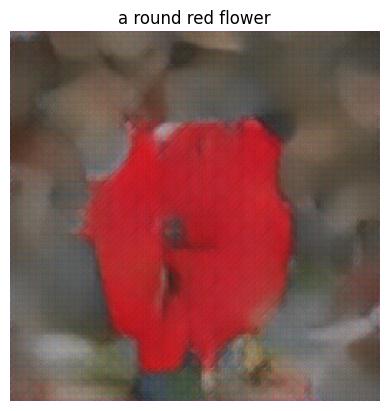

In [61]:
t = 'a round red flower' 
text_ids = tokenizer.encode(t).ids        
text_tokens = [tokenizer.encode('[BOS]').ids[0]]  + text_ids + [tokenizer.encode('[SEP]').ids[0]] 
k = model.generate(text_tokens,temperature=1)
print(k)

img_embeddings = emb_model.decode_indices(k)

H, W = 14, 14
# The output shape will be (1, H, W, embedding_dim), e.g., (1, 14, 14, 256)
reshaped_embeddings = tf.reshape(img_embeddings, (1, H, W, emb_model.embedding_dim))
generated_image = emb_model.decoder(reshaped_embeddings)

plt.title(t)
plt.imshow(generated_image[0]) # [0] to select the first image in the batch
plt.axis('off')
plt.show()

In [66]:
df['text'].values[:50]

array(['this flower is purple and yellow in color, with petals that are ruffled on the edges.',
       'a pink petal flower with a circular mass of yellow stamen in the middle.',
       'many light purple petals surround a large group of small yellow stamen with thick yellow anthers.',
       'this flower has thin purple petals as its main feature.',
       'the flower shown has purple petals with yellow pistil in the center',
       'this flower has layered lavender petals with smooth round edges.',
       'this flower has petals that are pink and has yellow stamen',
       'this flower has small oblong shaped purple petals that are arranged close together.',
       'this lilac purple flower has rounded, toothed edged petals, that surround a round bright yellow center.',
       'this flower is purple in color, and has petals that are are oval shaped and ruffled.',
       'the flower shown has purple petals with yellow anther and filament',
       'this flower has long pink petals and 

tf.Tensor(
[  55  316  316  673  492  474  965  446  863  770   27  269  715  563
    3  632  752  380  561  492  406  172  931  454   99  175  335  314
  114  451  491  201  837  267  201  956  172  238  378  175   25  238
  393  114  504  155   99  107  859  327  406  197  238  370  494  314
  238  186  931   90   99  237  676  238  931  936  238   28   28   28
   99  131  898  345  238   52  763  238   14  279   99  494   28  614
  218  238  752  917  238   52  491   99  464  238   99  655  238  513
  384  238  966  346  314   28  238   99  152  448  238  239  497  430
  384  238   28  388  396  238  840  204   74    1  238  952  824  288
  337  238  314   99  577  672  331   44  256  638  878  644    3  856
  374  238  238  359  629  986  576  951  238  238  378  131  619  715
  337  238   99  990  619   77   18  827  976   99  314   99  990  644
 1013  238  917  578  367 1013  937  138  779  239  314  314  357  644
 1013  388  241  919  619  989  965  417  766  746  835  644  851 

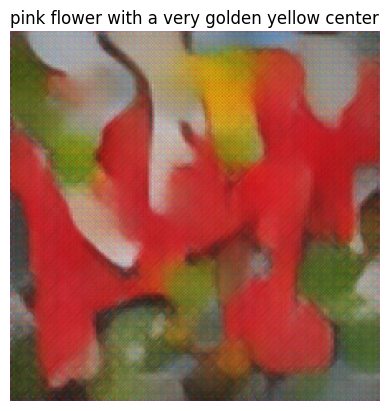

In [73]:
t = 'pink flower with a very golden yellow center' 
text_ids = tokenizer.encode(t).ids        
text_tokens = [tokenizer.encode('[BOS]').ids[0]]  + text_ids + [tokenizer.encode('[SEP]').ids[0]] 
k = model.generate(text_tokens,temperature=1)
print(k)

img_embeddings = emb_model.decode_indices(k)

H, W = 14, 14
# The output shape will be (1, H, W, embedding_dim), e.g., (1, 14, 14, 256)
reshaped_embeddings = tf.reshape(img_embeddings, (1, H, W, emb_model.embedding_dim))
generated_image = emb_model.decoder(reshaped_embeddings)

plt.title(t)
plt.imshow(generated_image[0]) # [0] to select the first image in the batch
plt.axis('off')
plt.show()